<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment" data-toc-modified-id="Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Missing-at-Random" data-toc-modified-id="Missing-at-Random-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Missing at Random</a></span></li><li><span><a href="#Structured-Missing" data-toc-modified-id="Structured-Missing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Structured Missing</a></span><ul class="toc-item"><li><span><a href="#Horizontal-Half-Mask" data-toc-modified-id="Horizontal-Half-Mask-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Horizontal Half Mask</a></span></li><li><span><a href="#Vertical-Half-Mask" data-toc-modified-id="Vertical-Half-Mask-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Vertical Half Mask</a></span></li></ul></li><li><span><a href="#Oneshot-Prediction" data-toc-modified-id="Oneshot-Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Oneshot Prediction</a></span></li><li><span><a href="#Autoregressive-Prediction" data-toc-modified-id="Autoregressive-Prediction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Autoregressive Prediction</a></span></li></ul></div>

# Tutorial 5 :  Neural Process Images

Last Update : 1 September 2019

**Aim**: 
- Test the best models (CCP and AttnNP) on image inputs.

In [ ]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/private/home/yannd/projects/NPF


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset 

- MNIST
- CelebA32
- CelebA64

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split

In [5]:
#celeba32_train, celeba32_test = train_dev_split(get_dataset("celeba32")(), dev_size=0.1, is_stratify=False)
#celeba64_train, celeba64_test = train_dev_split(get_dataset("celeba64")(), dev_size=0.1, is_stratify=False)
#svhn_train, svhn_test = get_dataset("svhn")(split="train"), get_dataset("svhn")(split="test")
mnist_train, mnist_test = get_dataset("mnist")(split="train"), get_dataset("mnist")(split="test")
#zs_mmnist_train, zs_mmnist_test = get_dataset("zs-multi-mnist")(split="train"), get_dataset("zs-multi-mnist")(split="test")

# celeba64 not fully trained yet
train_datasets = {"mnist":mnist_train}#, "celeba32":celeba32_train, "zs-multi-mnist":zs_mmnist_train}
test_datasets = {"mnist":mnist_test}#, "celeba32":celeba32_test, "zs-multi-mnist":zs_mmnist_test}

In [6]:
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

In [7]:
#plot_dataset_samples_imgs(celeba32_test, figsize=(9,5))

In [8]:
#plot_dataset_samples_imgs(celeba64_test, figsize=(9,5))

In [9]:
#plot_dataset_samples_imgs(mnist_test, figsize=(9,5))

In [10]:
#plot_dataset_samples_imgs(zs_mmnist_train, figsize=(9,5))
#plot_dataset_samples_imgs(zs_mmnist_test, figsize=(9,5))

In [11]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.0, max_nnz=0.01),
                                      target_masker=no_masker,
                                )

# Model

In [12]:
X_DIM = 2  # 2D spatial input 

In [13]:
from functools import partial
from neuralproc import GridConvCNP, AttnCNP
from neuralproc.architectures import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock, merge_flat_input, ConvBlock

In [14]:
kwargs = dict(r_dim=128,
              # make sure output is in 0,1 as images preprocessed so
              p_y_loc_transformer=lambda mu: torch.sigmoid(mu))

models_general = dict()

models_general["AttnCNP"] = partial(AttnCNP, x_dim=X_DIM, attention="transformer", **kwargs)




# models that take into account the grid
models_grided = {}
models_grided["GridedCCP"] = partial(GridConvCNP, 
                                     x_dim=1, # X_dim corresponds to the mask in the grid case
                                     # depth separable resnet
                                     CNN=partial(CNN, 
                                                     ConvBlock=ResConvBlock,
                                                     Conv=torch.nn.Conv2d,
                                                     n_blocks=7,  
                                                     Normalization=torch.nn.BatchNorm2d, 
                                                     is_chan_last=True,
                                                     kernel_size=11),
                                     **kwargs)



In [15]:
from utils.helpers import count_parameters
for k,v in models_general.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))
    
for k,v in models_grided.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))

AttnCNP - N Param: 240870
GridedCCP - N Param: 294769


/private/home/yannd/projects/NPF/neuralproc/architectures/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


No hyperparametur tuning was done. The hyperparameters were chosen such that :
- `SelfAttnCNP` was chosen to follow very closely the image model in the paper (the only difference being that it shares an XEncoder which decreases the number of parameter, gives at least as good results, and makes more sense)
- I chose the hyperparameter shuch that the largest internal representation (bottleneck) has 128 dimensions (as in the AttnNP paper).
- The number of layers in `GridedCCP` and `GridedUnetCCP` such that the final model has a simialr number of param than `SelfAttnCNP`.
- `AttnCNP` is `SelfAttnCNP` without self attnetion => less param.



In [16]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

In [17]:
# removing the following until they are fully trained
#SelfAttnCNP = models_general.pop("SelfAttnCNP")
#GridedUnetCCP = models_grided.pop("GridedUnetCCP")

## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [18]:
from neuralproc import CNPFLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

In [19]:

trainers_general = train_models(train_datasets, 
                                 add_y_dim(models_general, train_datasets),
                                 CNPFLoss,
                                 test_datasets=test_datasets,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
                                 patience=10,
                                 batch_size=16,
                                device="cuda:1",
                                 seed=123) 


--- Loading mnist/AttnCNP/run_0 ---

mnist/AttnCNP/run_0 | best epoch: 4 | train loss: -1169.7556 | valid loss: -1191.9013 | test log likelihood: 1203.4025


In [20]:

trainers_grided = train_models(train_datasets, 
                                 add_y_dim(models_grided, train_datasets),
                                 CNPFLoss,
                                 test_datasets=test_datasets,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_return_masks=True),
                                 patience=10,
                                 batch_size=4,
                                #device="cuda:1",
                                 seed=123) 


--- Loading mnist/GridedCCP/run_0 ---

mnist/GridedCCP/run_0 | best epoch: 3 | train loss: -1193.8826 | valid loss: -1232.0554 | test log likelihood: 1241.6533


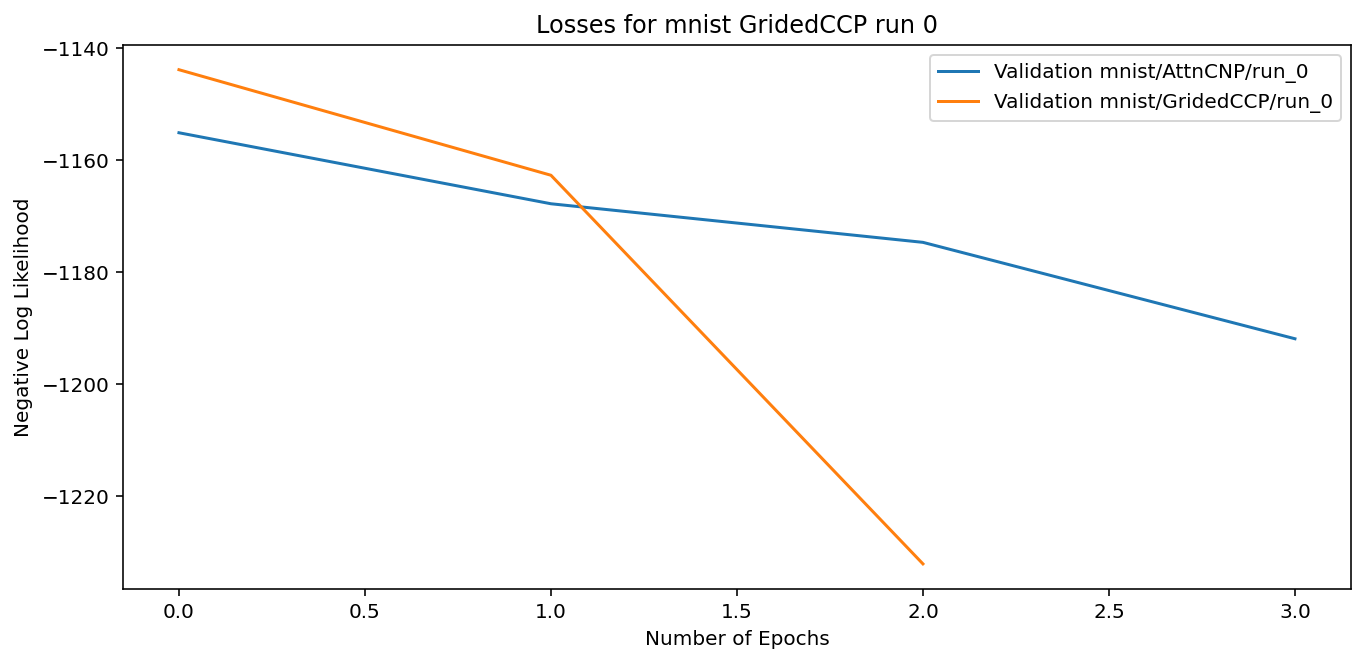

In [21]:
trainers = dict()
trainers.update(trainers_general)
trainers.update(trainers_grided)

n_datasets = len(train_datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True)

if n_datasets ==1:
    axes = [axes]

datanames = dict()
for k, trainer in trainers.items():
    data_name = k.split("/")[0]
    datanames[data_name] = datanames.get(data_name, len(datanames))
    i = datanames[data_name]
    plot_losses(trainer.history, 
                title="Losses for {}".format(" ".join(k.split("/")).replace("_", " ")), 
                ax=axes[i],
                mode="validation",
                label_sfx=" {}".format(k))
    #axes[i].set_ylim([-4, -0.])
    #axes[i].set_xlim([0, 25])

# One Shot Inference 

In [22]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE


## Missing at Random

random with only 5 % of the data. The distribution show the distribution of log likelihood for the entire test set. The qualitative results are the images (from left to right) corresponding to 1% 50% and 99% percentile for `GridedCCP` folowed by 1% 50% and 99% percentile for `AttnCCP`.

The first row is `GridedCCP`, while the second is `AttnCCP`.



In [23]:
trainers_compare = trainers_grided.copy()
trainers_compare.update(trainers_general)

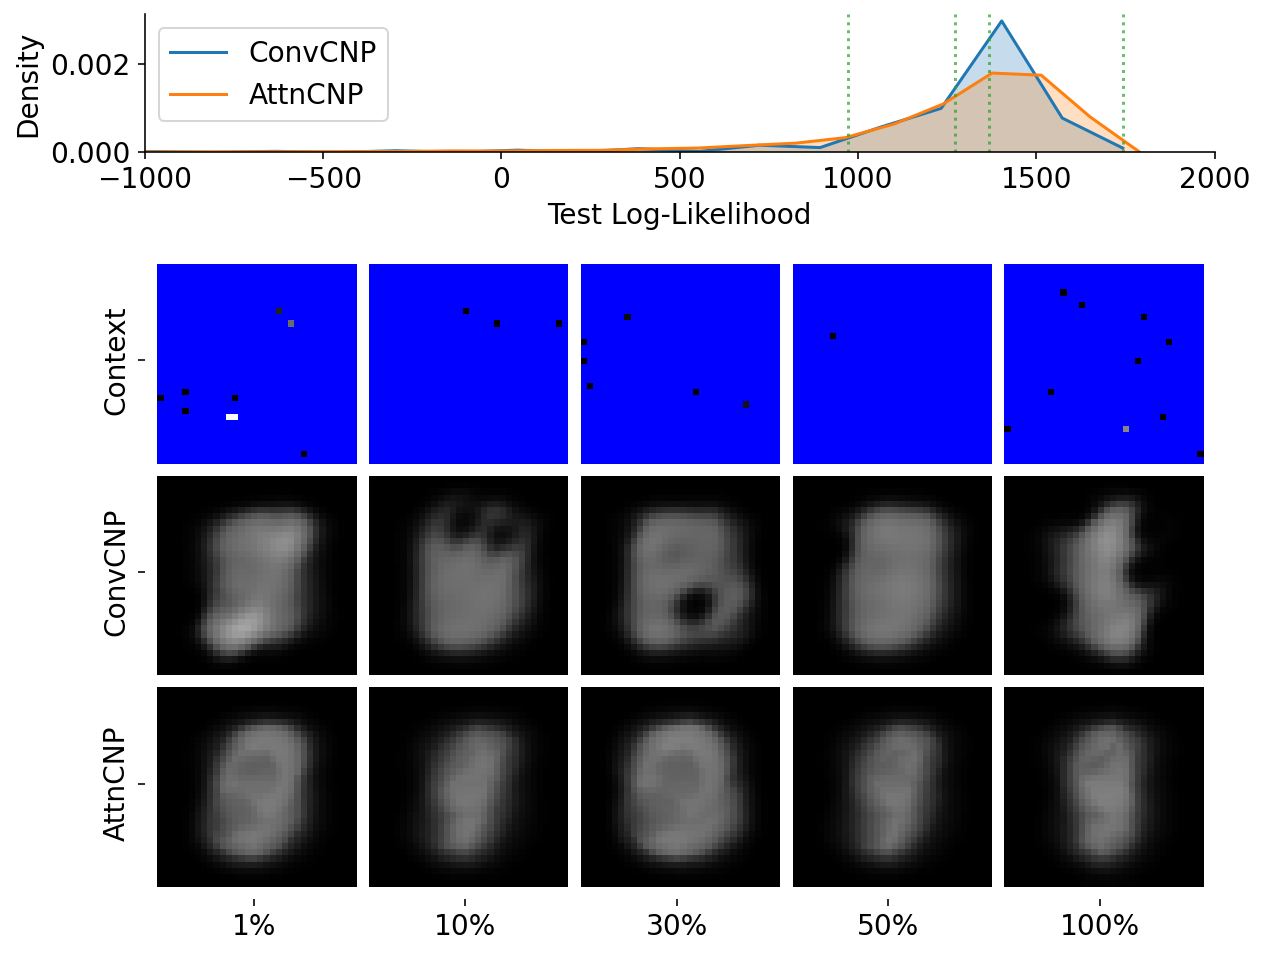

In [25]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde(["ConvCNP", trainers_grided['{}/GridedCCP/run_0'.format(data_name)]],
                                     test_data,
                                      named_trainer_compare=["AttnCNP", trainers_general['{}/AttnCNP/run_0'.format(data_name)]],
                                             figsize=(9, 7),
                                         percentiles=[1,10,30,50,100],
                                        height_ratios=[1,5],
                                         x_lim={"left":-1000, "right":2000},
                                         h_pad=0)

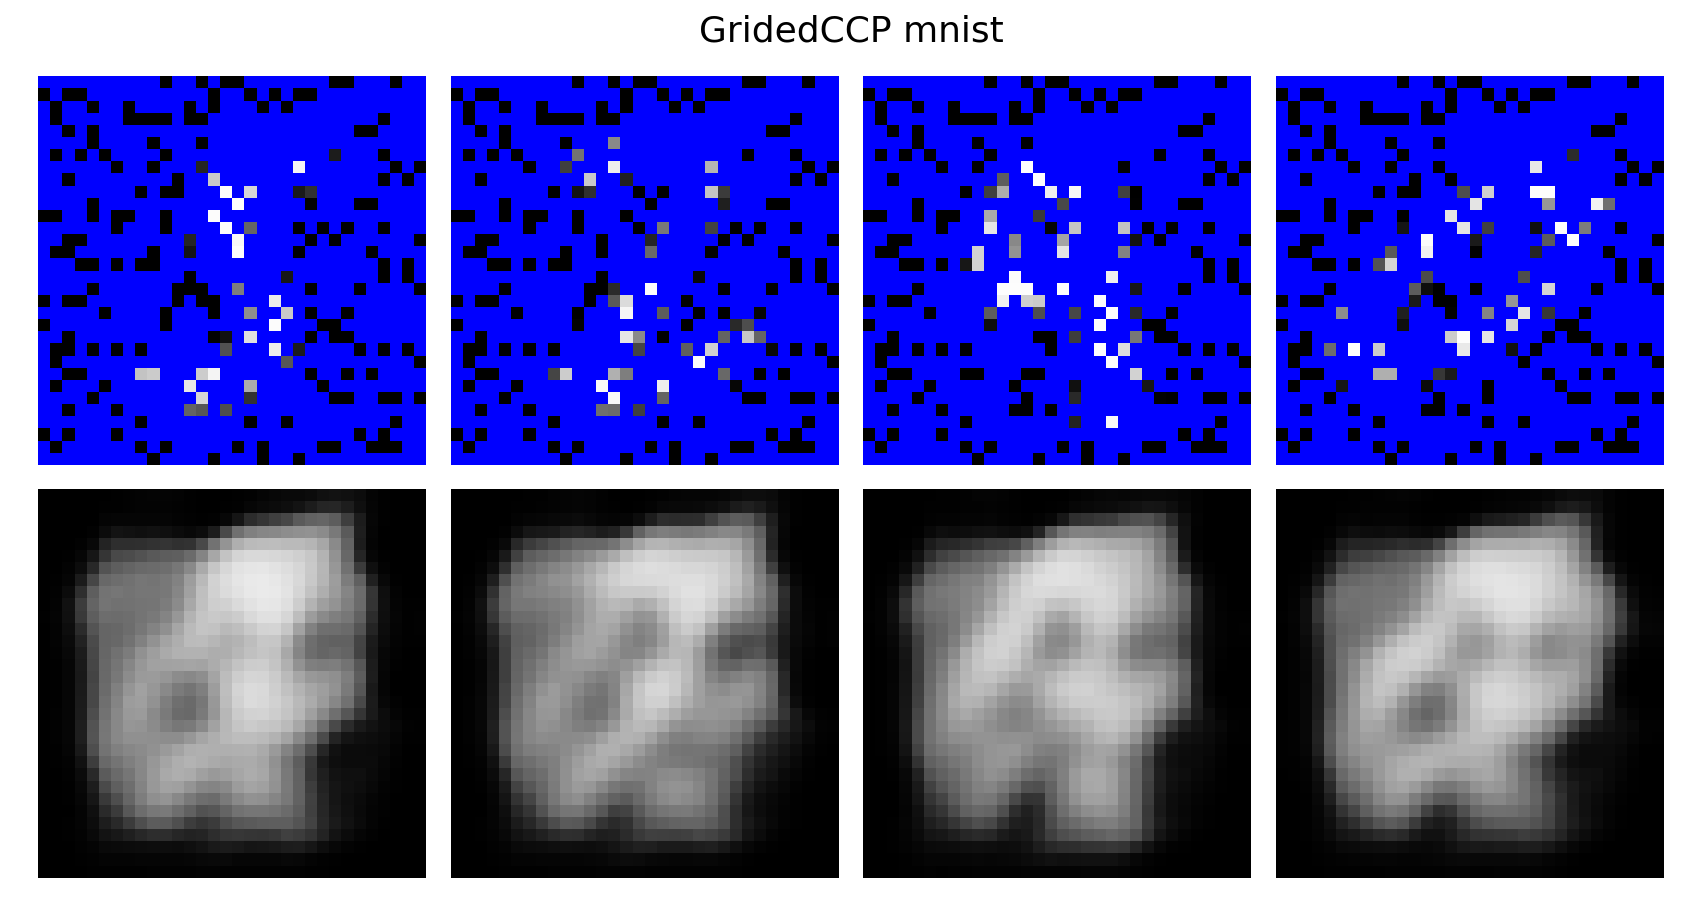

In [26]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=VanillaPredictor,
                             n_plots=4,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

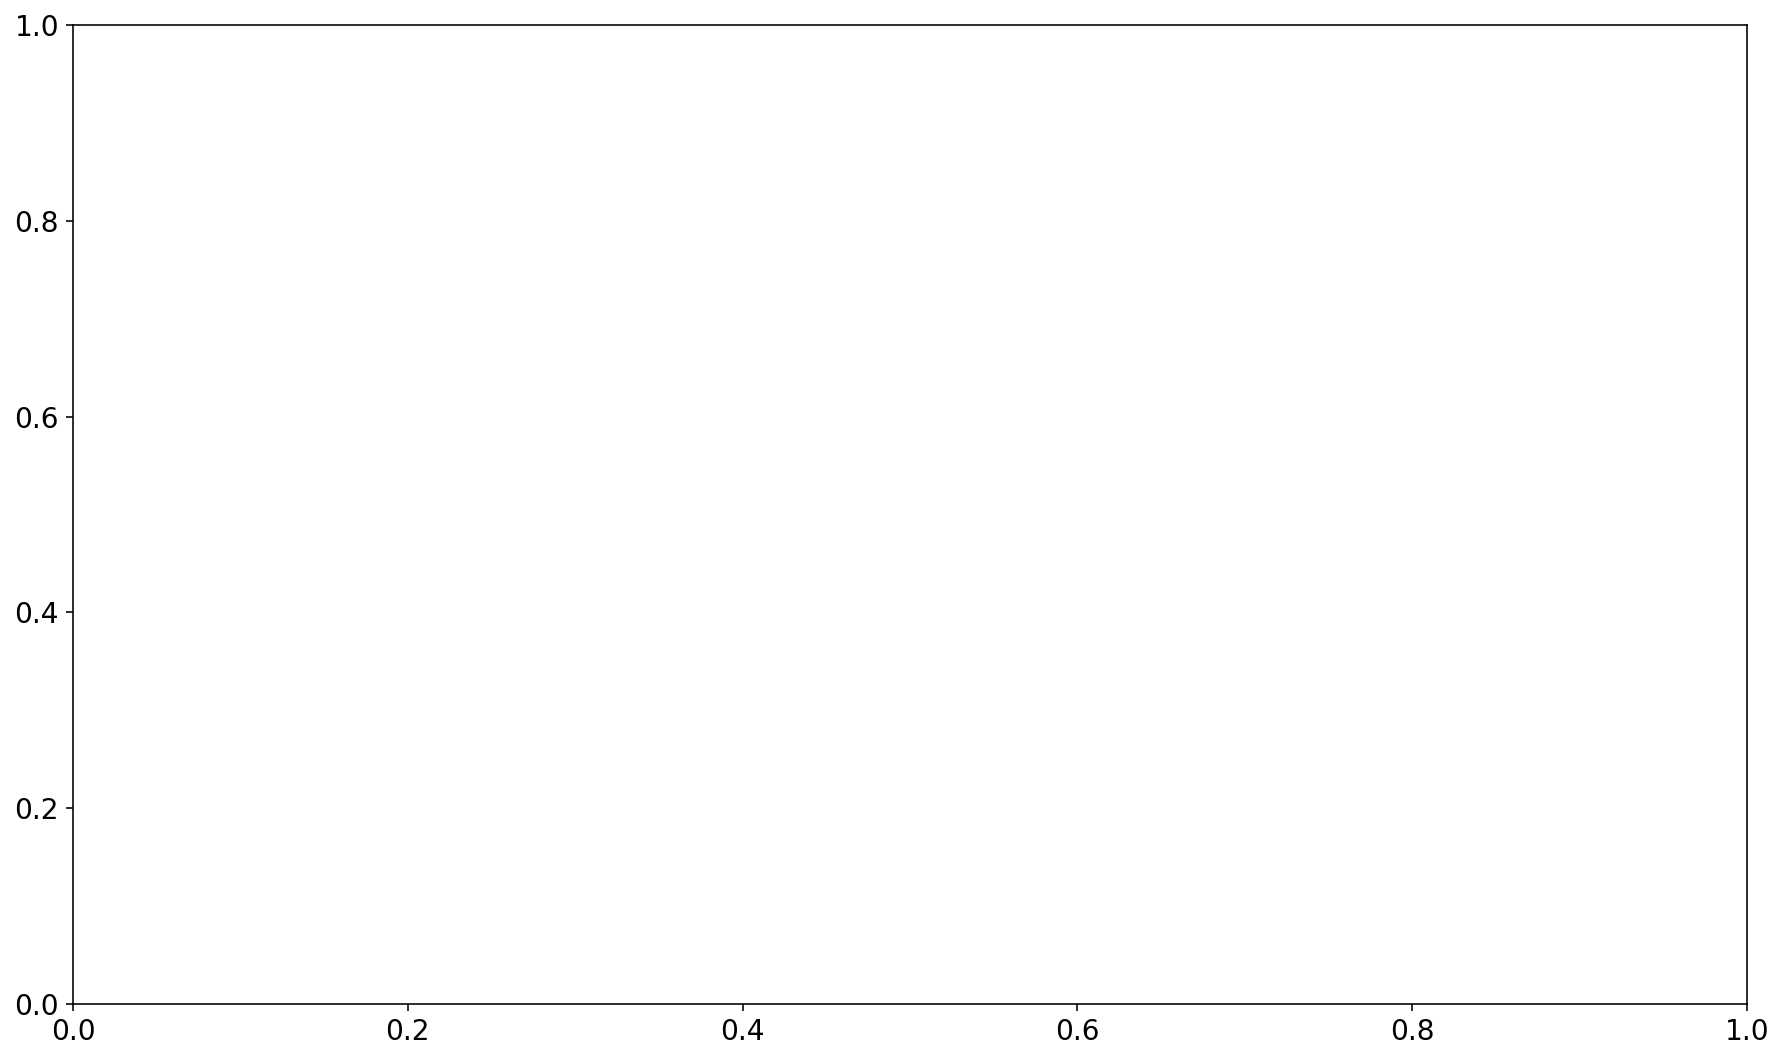

In [27]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "zs-multi-mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=AutoregressivePredictor,
                             n_plots=8,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

## Structured Missing

### Horizontal Half Mask

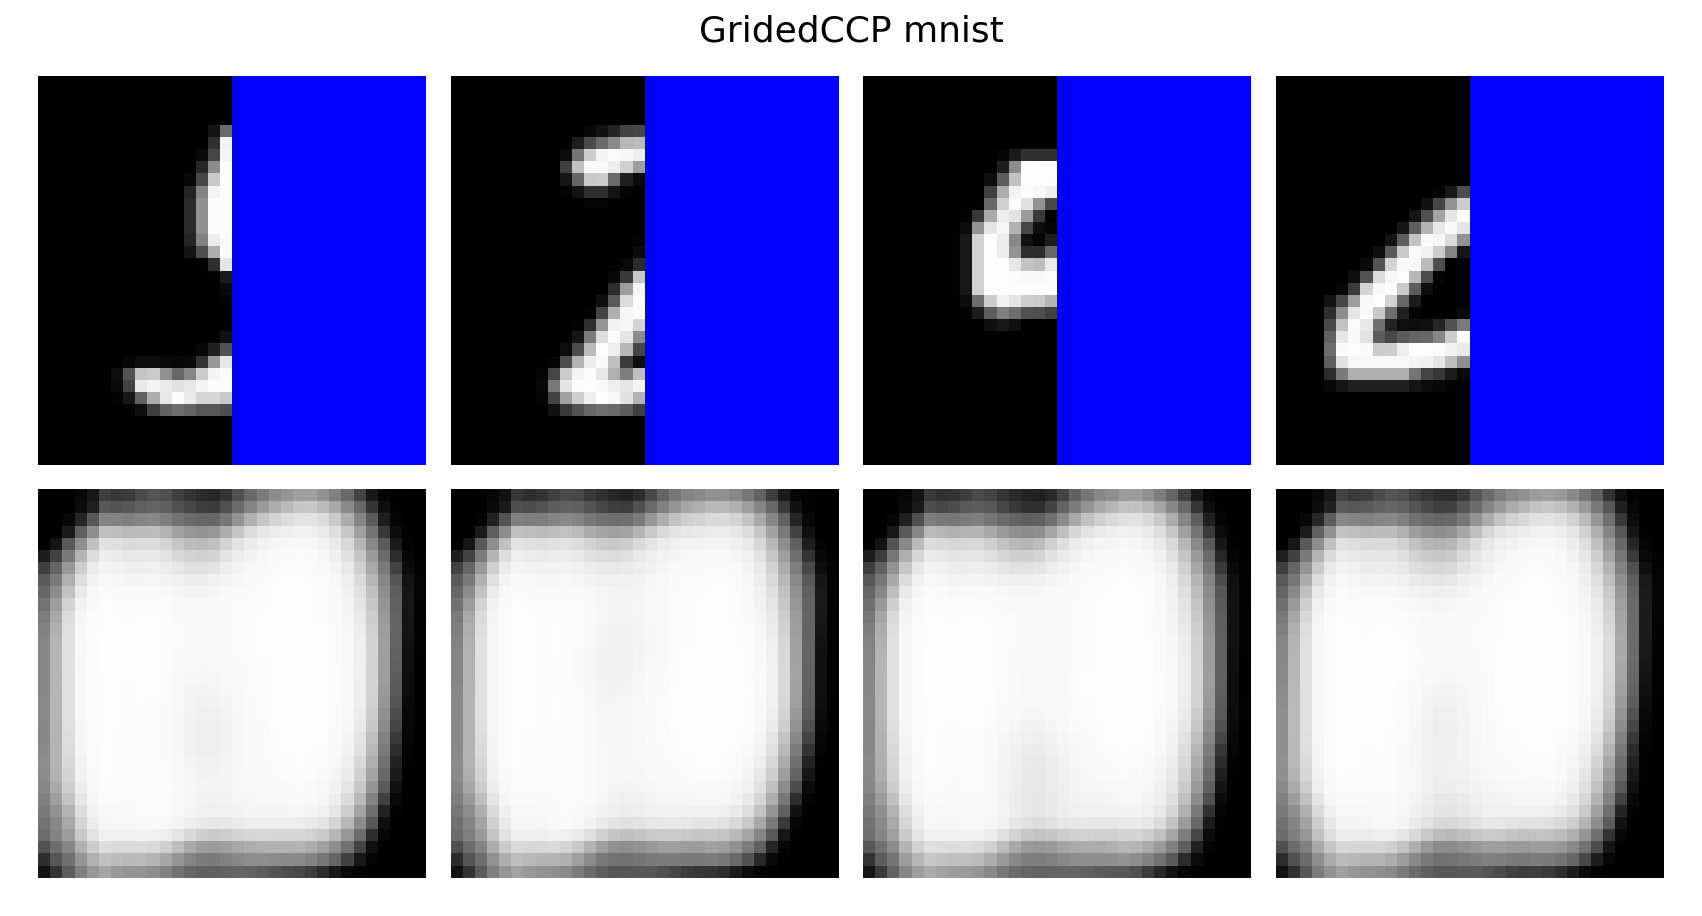

In [28]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

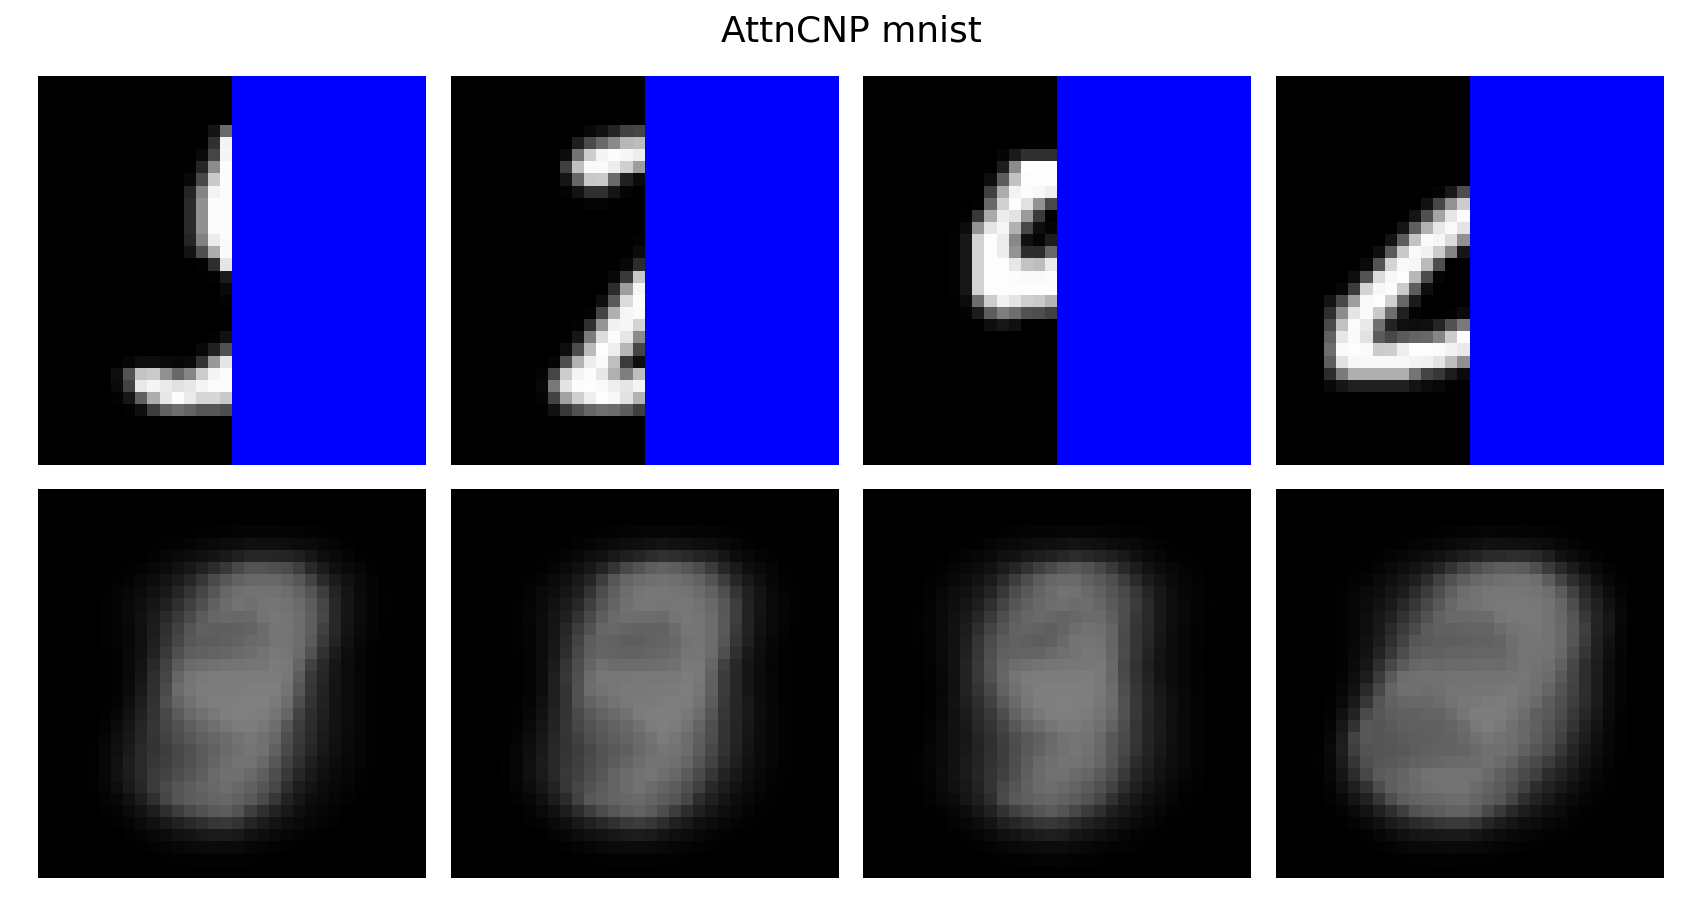

In [29]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_general['{}/AttnCNP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=False, # AttnCNP doesn't assume grid input
                         ax=axes[i])
    
    axes[i].set_title("AttnCNP " + data_name, fontsize=18)

### Vertical Half Mask

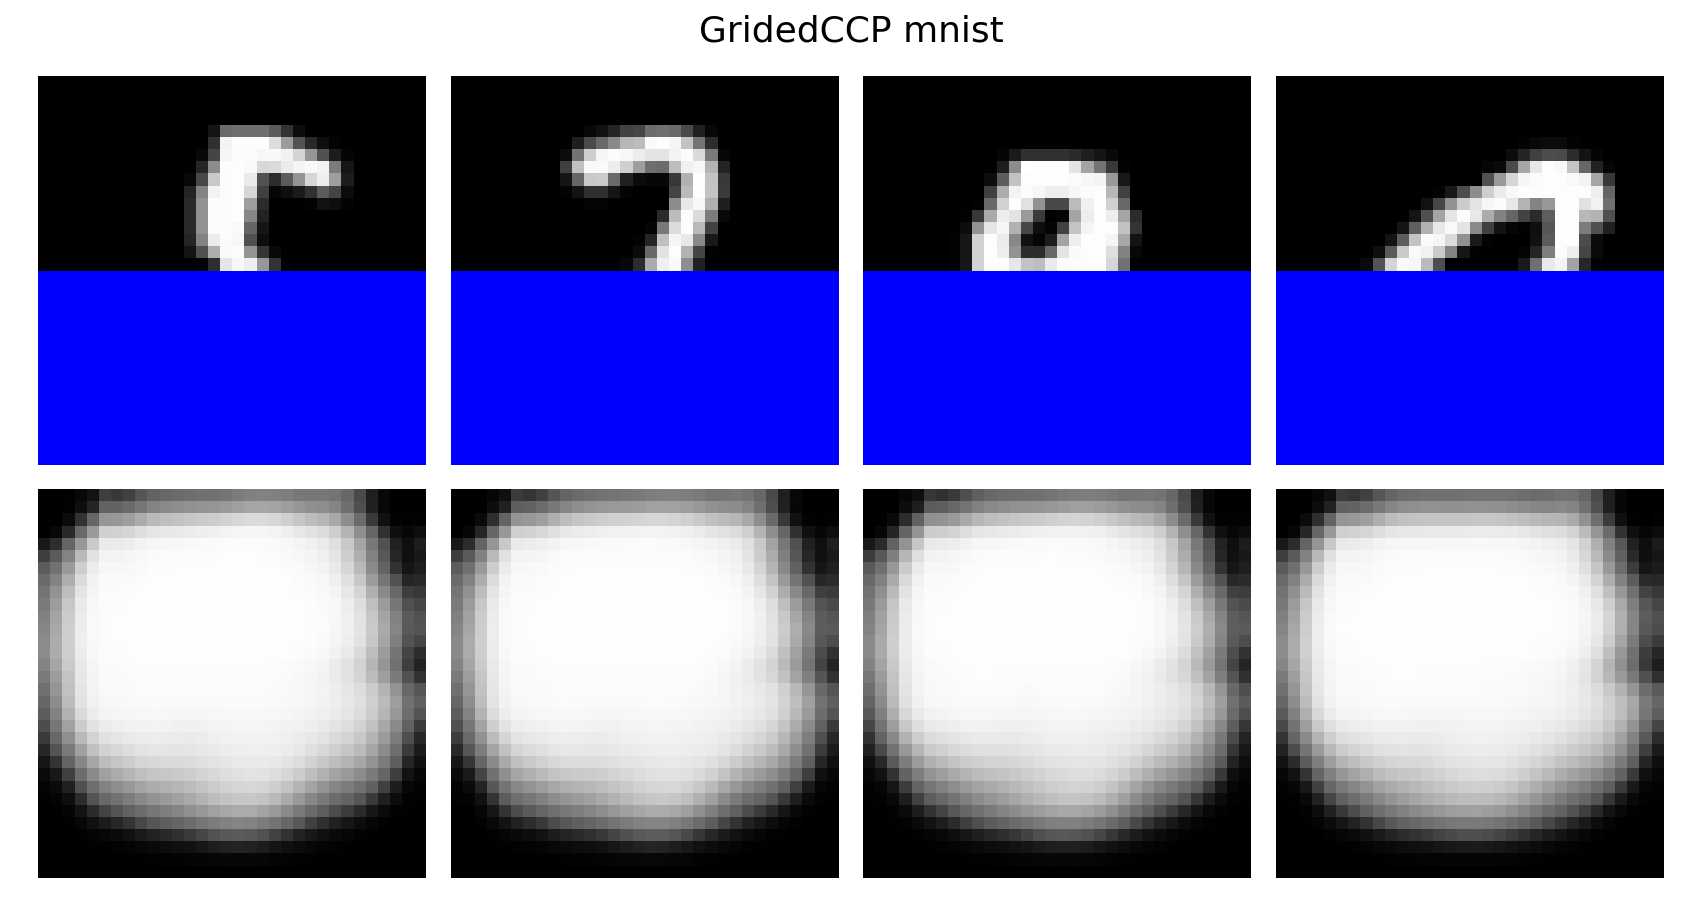

In [30]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), # change dim=0 for vertical
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

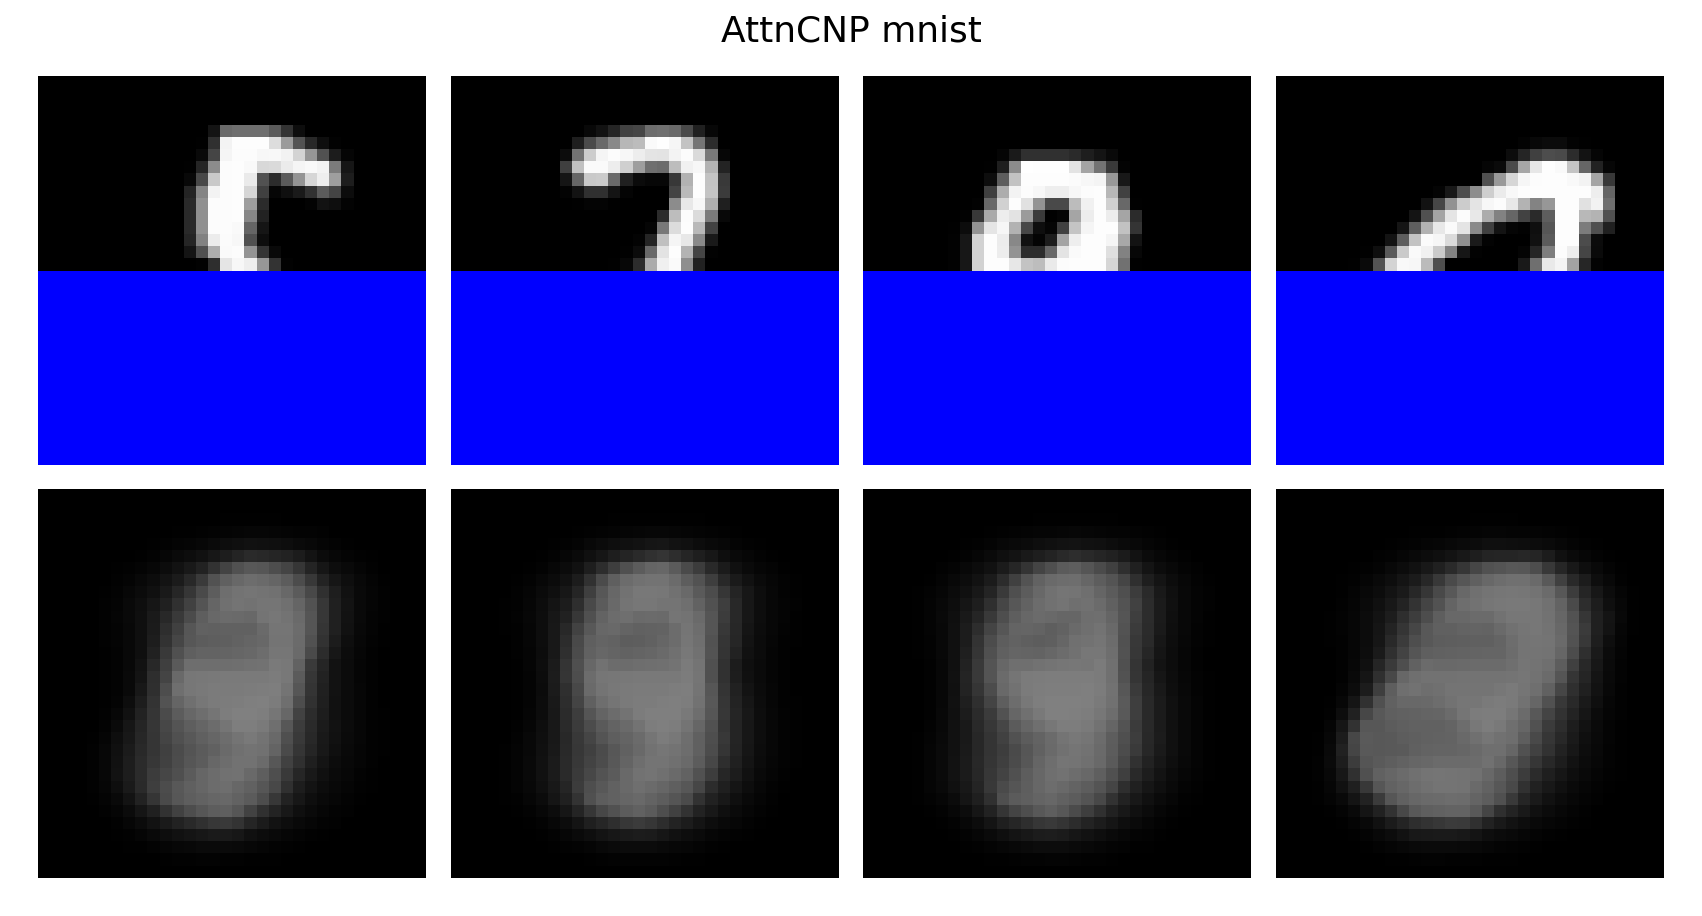

In [31]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0),
                                         target_masker=no_masker), 
                         trainers_general['{}/AttnCNP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=False,
                         ax=axes[i])
    
    axes[i].set_title("AttnCNP " + data_name, fontsize=18)

# Autoregressive Inference 

Autoregressive is as James suggested : predict all neighbors (1 manhattan distance) of context, treat it as context, predict next neighbours.

RuntimeError: shape mismatch: value tensor of shape [5120, 1] cannot be broadcast to indexing result of shape [109, 1]

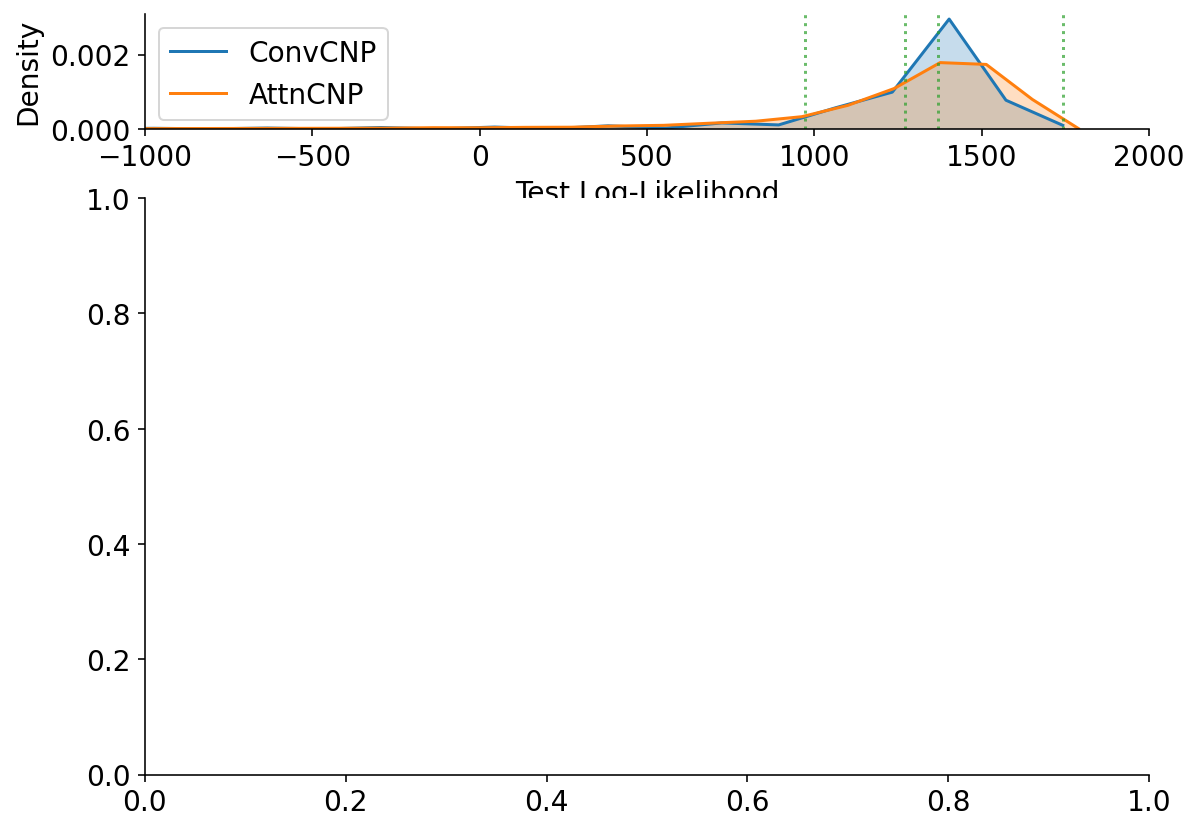

In [24]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde(["ConvCNP", trainers_grided['{}/GridedCCP/run_0'.format(data_name)]],
                                     test_data,
                                      named_trainer_compare=["AttnCNP", trainers_general['{}/AttnCNP/run_0'.format(data_name)]],
                                             figsize=(9, 7),
                                         percentiles=[1,10,30,50,100],
                                        height_ratios=[1,5],
                                         x_lim={"left":-1000, "right":2000},
                                             MeanPredictor=AutoregressivePredictor,
                                         h_pad=0)
    

RuntimeError: Expected object of scalar type Long but got scalar type Bool for sequence element 1 in sequence argument at position #1 'tensors'

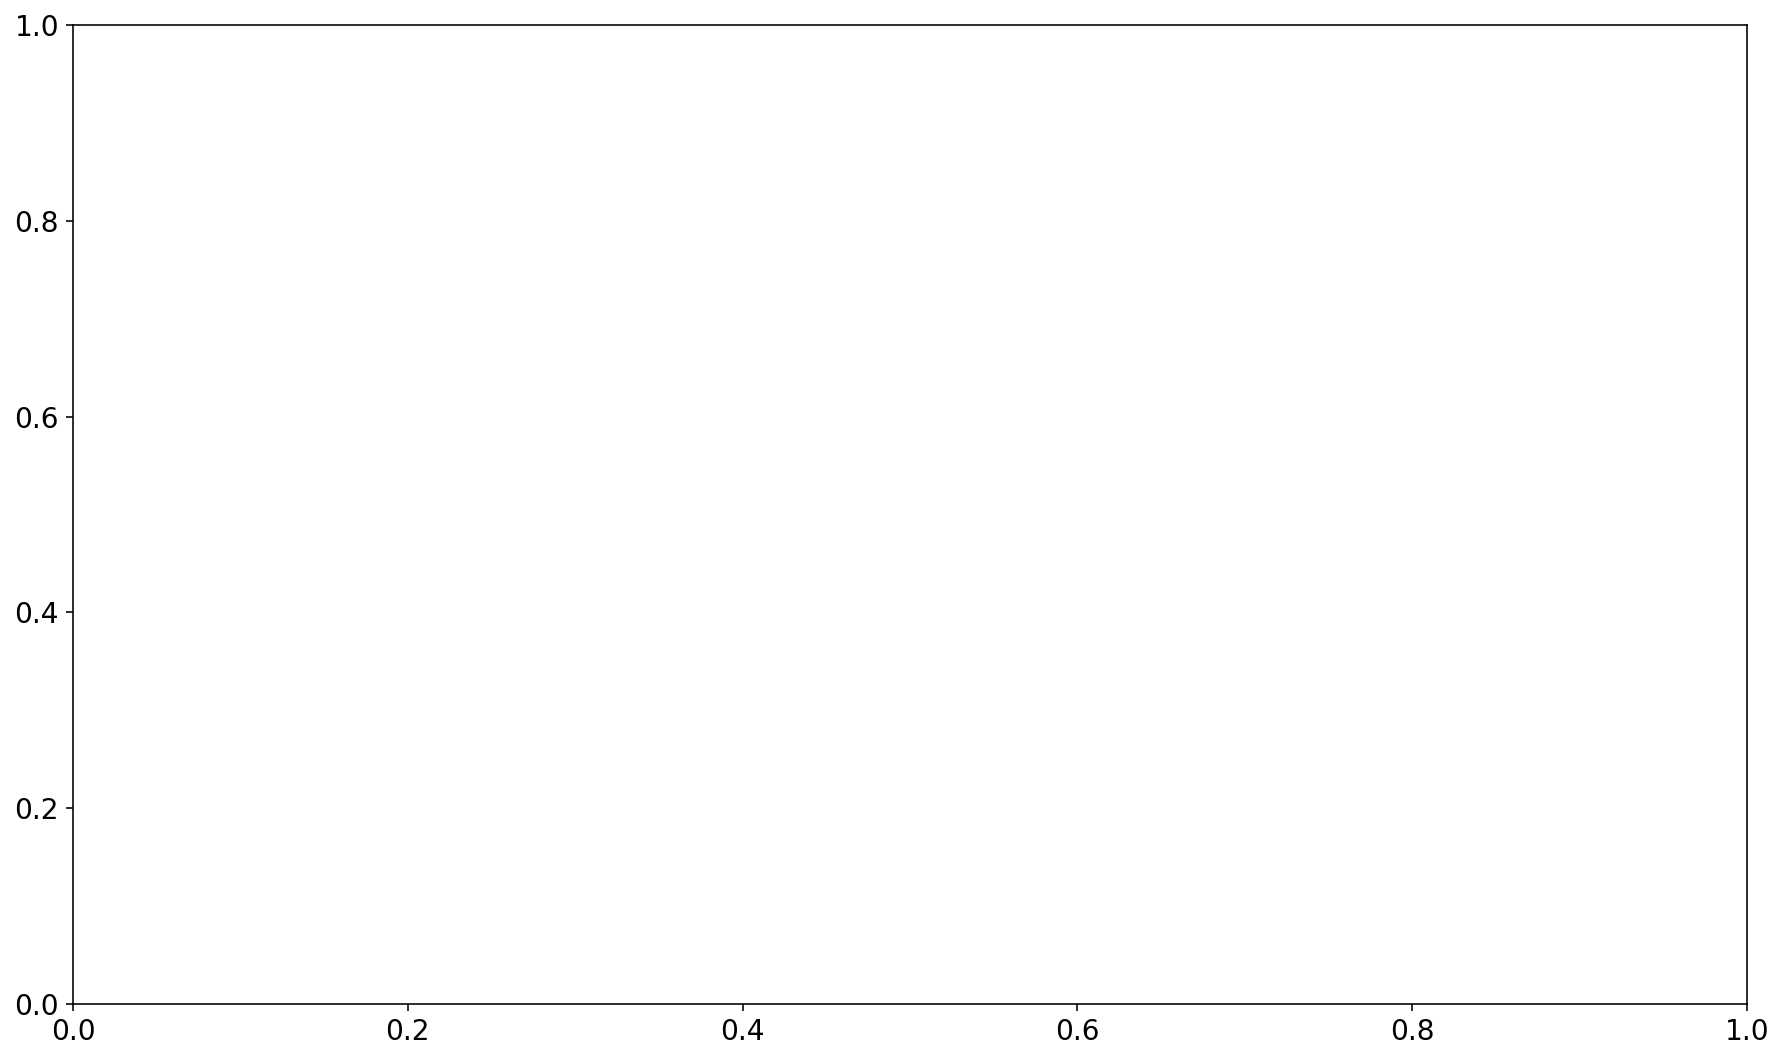

In [40]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

RuntimeError: Expected object of scalar type Long but got scalar type Bool for sequence element 1 in sequence argument at position #1 'tensors'

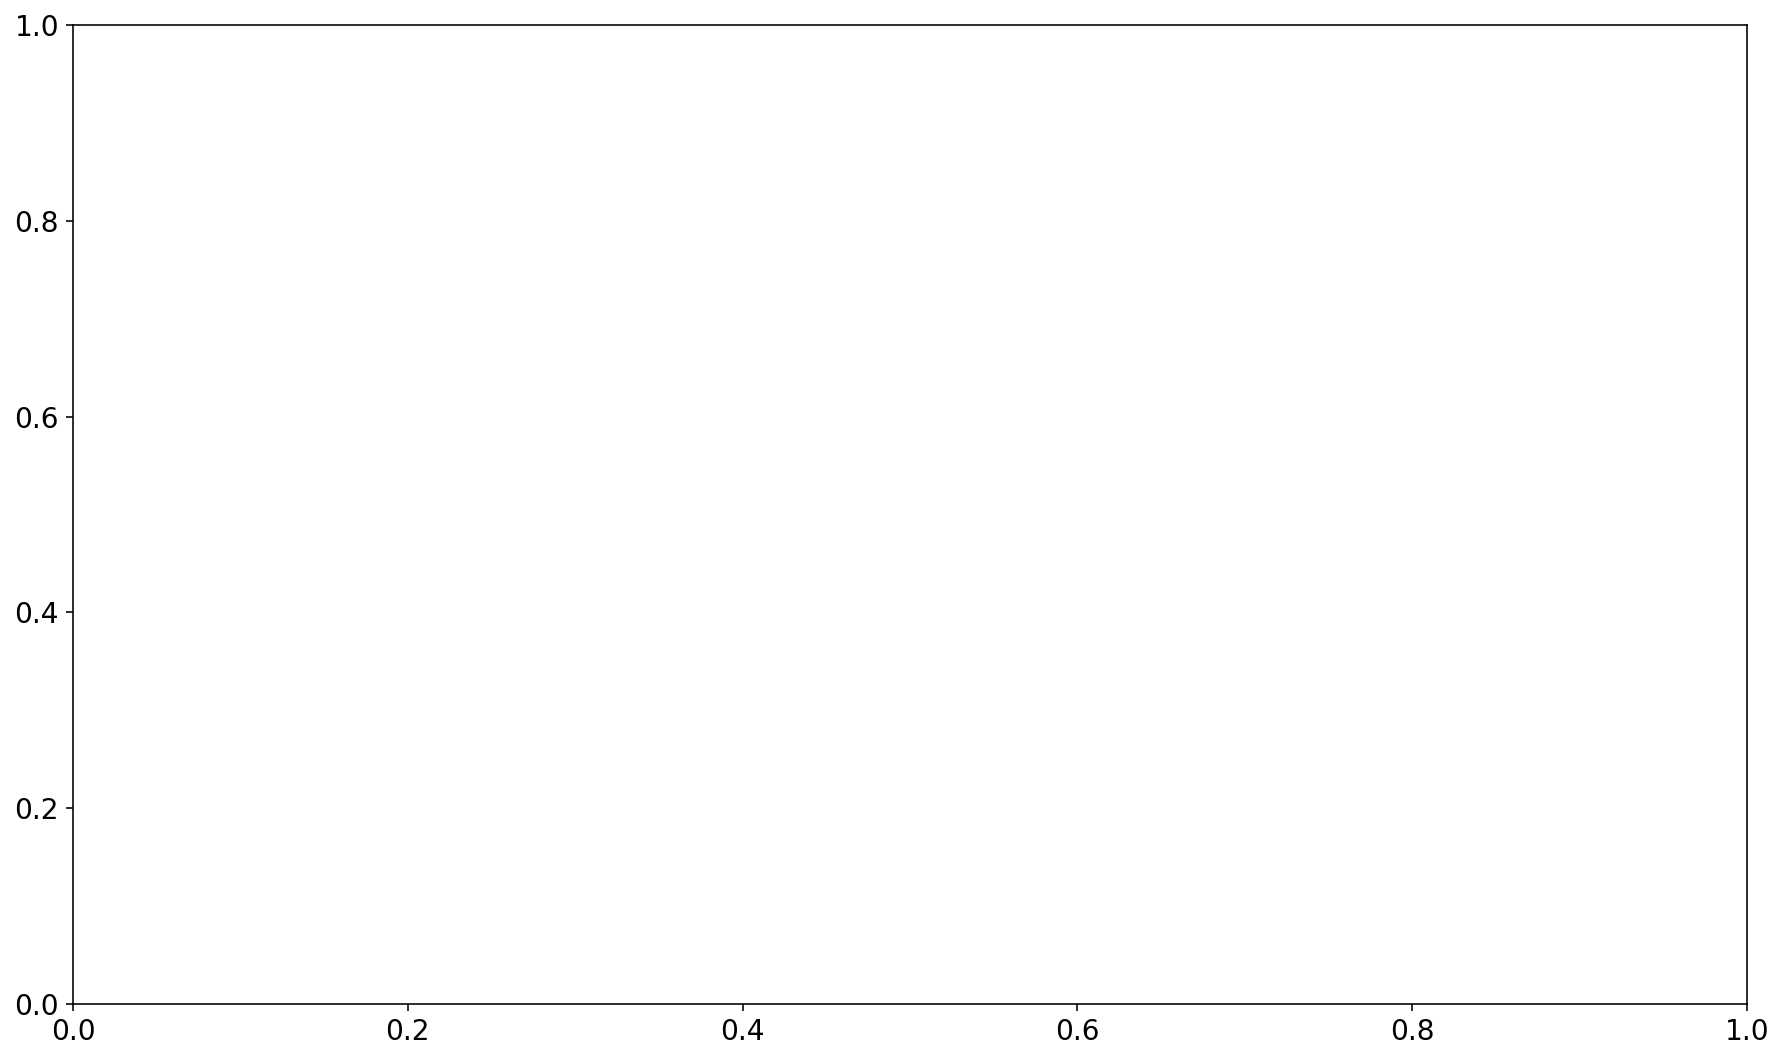

In [41]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), # change dim=0 for vertical
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

# CelebA64

I did not plot all CelebA64, as not all models are trained yet. Here I show `GridedUnetCCP` which finished training.

In [42]:
train_datasets64 = dict(celeba64=celeba64_train)
test_datasets64 = dict(celeba64=celeba64_test)

NameError: name 'celeba64_train' is not defined

In [43]:
trainers_grided64 = train_models(train_datasets64, 
                                 add_y_dim(dict(GridedUnetCCP=GridedUnetCCP), train_datasets64),
                                 NeuralProcessLoss,
                                 test_datasets=test_datasets64,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

NameError: name 'train_datasets64' is not defined

## Oneshot Prediction

In [44]:
for data_name, test_data in test_datasets64.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided64.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=VanillaPredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

NameError: name 'test_datasets64' is not defined

In [45]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

NameError: name 'test_datasets64' is not defined

In [46]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

NameError: name 'test_datasets64' is not defined

## Autoregressive Prediction

ValueError: not enough values to unpack (expected 2, got 1)

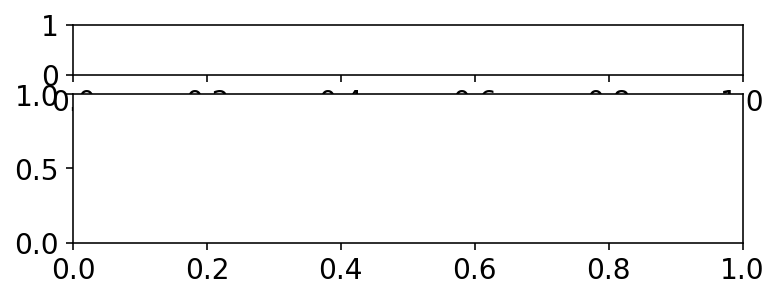

In [50]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=AutoregressivePredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

RuntimeError: Expected object of scalar type Long but got scalar type Bool for sequence element 1 in sequence argument at position #1 'tensors'

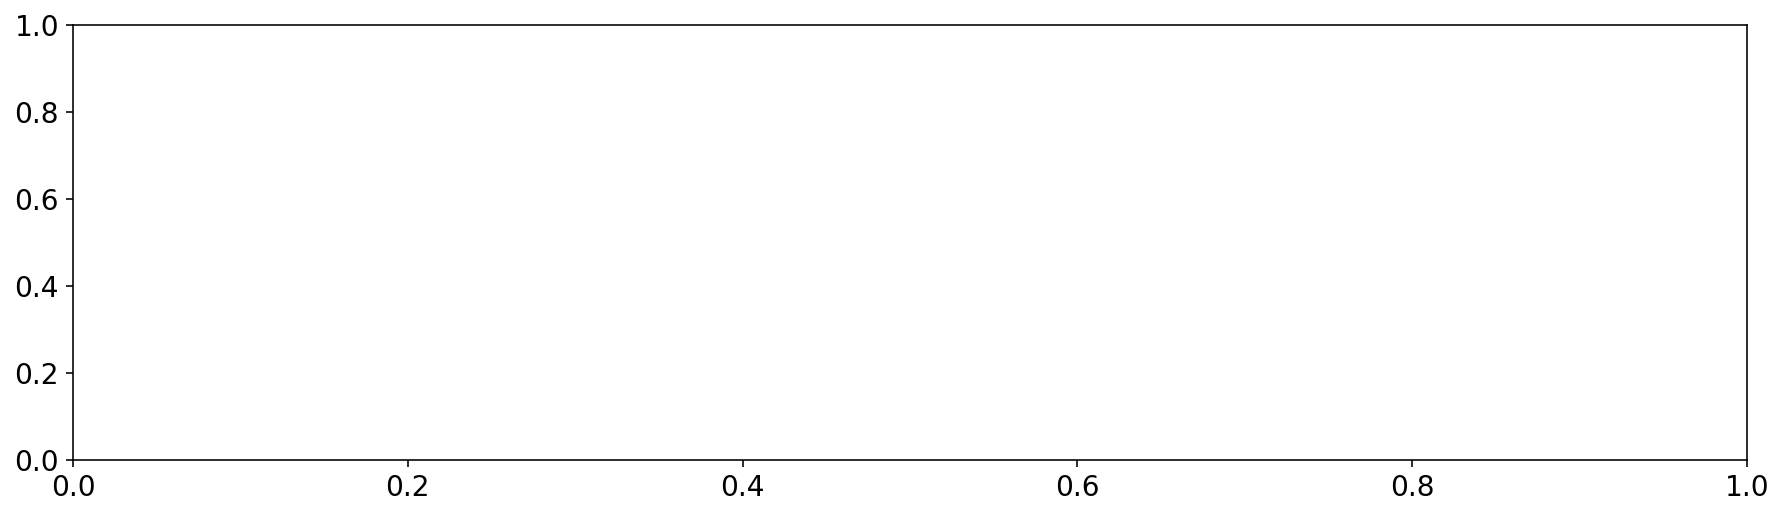

In [53]:
n_datasets = len(test_datasets)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

RuntimeError: Expected object of scalar type Long but got scalar type Bool for sequence element 1 in sequence argument at position #1 'tensors'

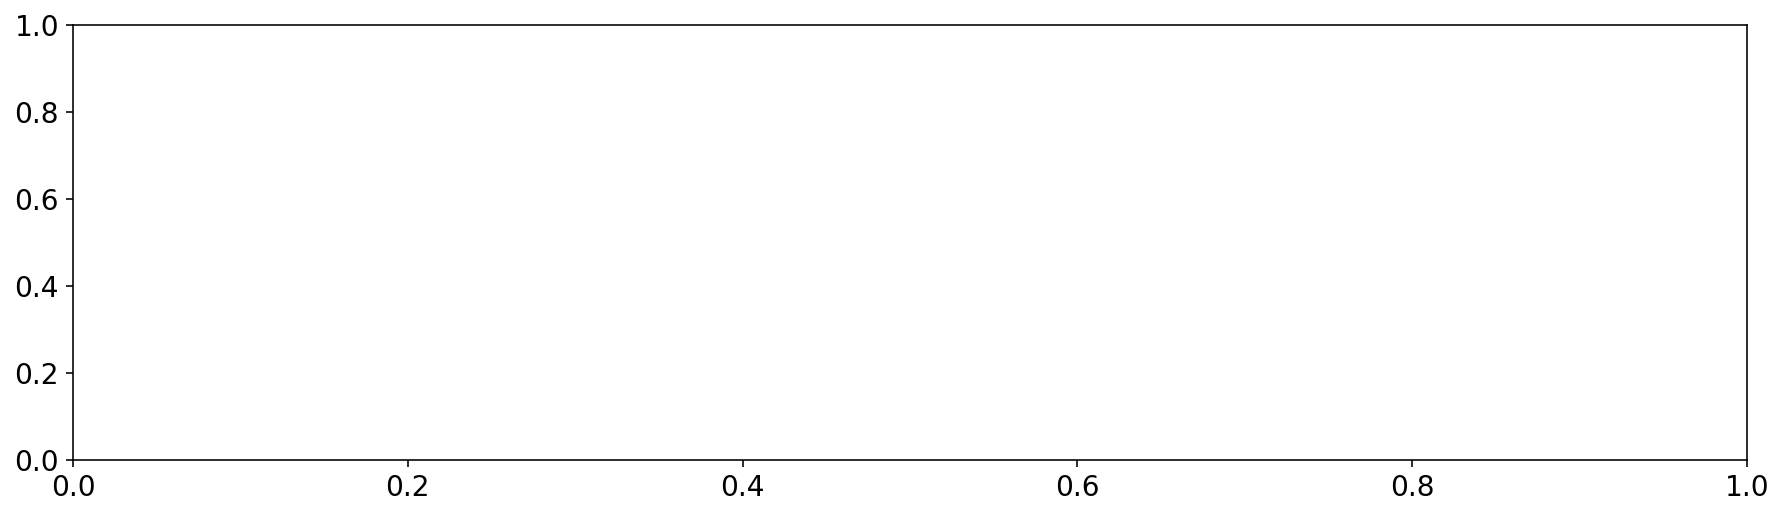

In [55]:
n_datasets = len(test_datasets)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)